In [ ]:
# Clone the repository
!git clone https://github.com/sveitser/kaggle_diabetic.git

# Navigate to the repository directory
%cd kaggle_diabetic
# Install dependencies
!pip install -r requirements.txt
!pip install tensorflow keras opencv-python matplotlib numpy pandas scikit-learn

Cloning into 'kaggle_diabetic'...
remote: Enumerating objects: 1554, done.
remote: Total 1554 (delta 0), reused 0 (delta 0), pack-reused 1554 (from 1)
Receiving objects: 100% (1554/1554), 350.86 KiB | 10.02 MiB/s, done.
Resolving deltas: 100% (1279/1279), done.
/content/kaggle_diabetic
Obtaining Lasagne-master from git+https://github.com/benanne/Lasagne.git@9f591a5f3a192028df9947ba1e4903b3b46e8fe0#egg=Lasagne-master (from -r requirements.txt (line 3))
  Cloning https://github.com/benanne/Lasagne.git (to revision 9f591a5f3a192028df9947ba1e4903b3b46e8fe0) to ./src/lasagne-master
  Running command git clone --filter=blob:none --quiet https://github.com/benanne/Lasagne.git /content/kaggle_diabetic/src/lasagne-master
  Running command git rev-parse -q --verify 'sha^9f591a5f3a192028df9947ba1e4903b3b46e8fe0'
  Running command git fetch -q https://github.com/benanne/Lasagne.git 9f591a5f3a192028df9947ba1e4903b3b46e8fe0
  Running command git checkout -q 9f591a5f3a192028df9947ba1e4903b3b46e8fe0
 

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c diabetic-retinopathy-detection
!kaggle competitions download -c diabetic-retinopathy-classification-f1-score-4
!7z x diabetic-retinopathy-classification-f1-score-4.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 623713790 bytes (595 MiB)

Extracting archive: diabetic-retinopathy-classification-f1-score-4.zip
--
Path = diabetic-retinopathy-classification-f1-score-4.zip
Type = zip
Physical Size = 623713790

  0%      2% 86 - kaggle_retina/test/107aea0d9289.png                                               5% 167 - kaggle_retina/test/1e4650743fa2.png                                                7% 268 - kaggle_retina/test/2fe06bedb2c4.png                                              

In [ ]:
import random
import numpy as np
import tensorflow as tf
seed=7
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

labels = pd.read_csv('/content/kaggle_diabetic/kaggle_retina/train.csv')
# Rename columns and add ".jpeg" extension
labels.columns = ['image', 'level']
labels['image'] = labels['image'] + '.png'  # Add extension here
labels['level'] = labels['level'].astype(str)
labels

,image,level
0,c1e6fa1ad314.png,1
1,ed246ae1ed08.png,4
2,4d3de40ced3a.png,0
3,ae8472f8d310.png,1
4,3c28fd846b43.png,0
...,...,...
2192,87774aafe068.png,4
2193,1b4625877527.png,2
2194,bfe467b7e997.png,2
2195,d2cd47ed2c1d.png,0


Found 1758 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.


<Axes: xlabel='level'>

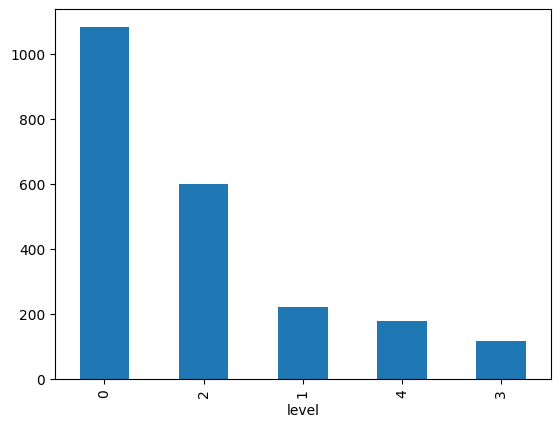

In [ ]:
#data preprocessing
import cv2
import numpy as np
#detect and correct inverted images
def fix_inversion(image_path):
    image = cv2.imread(image_path)
    # Check for inversion using macula position or notch presence
    # (Implement your inversion detection logic here)
    if is_inverted(image):
        image = cv2.flip(image, 0)  # Flip vertically
    return image
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels['level']),
    y=labels['level']
)
class_weights_dict = dict(enumerate(class_weights))
# Use albumentations for advanced augmentation
def augment(image):
    return A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(p=0.1),
        A.CLAHE(p=0.1),
    ])(image=image)["image"]

train_datagen = ImageDataGenerator(
    preprocessing_function=augment,
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/kaggle_diabetic/kaggle_retina/train',  # Path to your images
    x_col='image',                    # Column with filenames
    y_col='level',                    # Column with labels
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/kaggle_diabetic/kaggle_retina/train',
    x_col='image',
    y_col='level',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)
labels['level'].value_counts().plot(kind='bar')

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
# Load ResNet50 pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pretrained layers
base_model.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  # 5 neurons + softmax

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

# Custom F1-score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()
#focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # Fix for sparse labels
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return loss_fn


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_loss(),
    metrics=['accuracy', F1Score()]
)

In [ ]:
history = model.fit(train_generator,
    validation_data=val_generator, batch_size = 128, epochs = 40, verbose = 1, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ])

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7293 - f1_score: 0.9364 - loss: 0.1083

55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7294 - f1_score: 0.9365 - loss: 0.1082 - val_accuracy: 0.2415 - val_f1_score: 0.6491 - val_loss: 0.2923
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7500 - f1_score: 0.9366 - loss: 0.0903

55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7500 - f1_score: 0.9365 - loss: 0.0904 - val_accuracy: 0.3440 - val_f1_score: 0.6215 - val_loss: 0.2084
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7862 - f1_score: 0.9538 - loss: 0.0825

55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7859 - f1_score: 0.9537 - loss: 0.0825 - val_accuracy: 0.5216 - val_f1_score: 0.0000e+00 - val_loss: 0.1853
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7744 - f1_score: 0.9224 - loss: 0.0796 - val_accuracy: 0.3986 - val_f1_score: 0.6273 - val_loss: 0.1927
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7569 - f1_score: 0.9339 - loss: 0.0860

55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7569 - f1_score: 0.9340 - loss: 0.0860 - val_accuracy: 0.5376 - val_f1_score: 0.2083 - val_loss: 0.1721
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7961 - f1_score: 0.9467 - loss: 0.0730

55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7959 - f1_score: 0.9467 - loss: 0.0730 - val_accuracy: 0.5011 - val_f1_score: 0.7554 - val_loss: 0.1652
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8171 - f1_score: 0.9381 - loss: 0.0665 - val_accuracy: 0.4579 - val_f1_score: 0.6205 - val_loss: 0.1925
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8026 - f1_score: 0.9518 - loss: 0.0693 - val_accuracy: 0.4601 - val_f1_score: 0.7582 - val_loss: 0.1894
Epoch 9/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7974 - f1_score: 0.9444 - loss: 0.0660 - val_accuracy: 0.4989 - val_f1_score: 0.7750 - val_loss: 0.1803
Epoch 10/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8149 - f1_score: 0.9432 - loss: 0.0643 - val_accuracy: 0.5125 - val_f1_score: 0.7475 - val_loss: 0.1909
Epoch 11/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8097 - f1_score: 0.9423 - loss: 0.0648 - val_accuracy: 0.5490 - val_f1_score: 0.7495 - val_loss: 0.1759
E

55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7963 - f1_score: 0.9375 - loss: 0.0679 - val_accuracy: 0.5558 - val_f1_score: 0.8121 - val_loss: 0.1526
Epoch 13/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8090 - f1_score: 0.9515 - loss: 0.0623 - val_accuracy: 0.3121 - val_f1_score: 0.6818 - val_loss: 0.2422
Epoch 14/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8333 - f1_score: 0.9631 - loss: 0.0575 - val_accuracy: 0.4692 - val_f1_score: 0.7614 - val_loss: 0.1832
Epoch 15/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8361 - f1_score: 0.9583 - loss: 0.0574 - val_accuracy: 0.4761 - val_f1_score: 0.7721 - val_loss: 0.1659
Epoch 16/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8389 - f1_score: 0.9472 - loss: 0.0577

55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8389 - f1_score: 0.9472 - loss: 0.0577 - val_accuracy: 0.5490 - val_f1_score: 0.7921 - val_loss: 0.1524
Epoch 17/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8208 - f1_score: 0.9560 - loss: 0.0583

55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8209 - f1_score: 0.9560 - loss: 0.0583 - val_accuracy: 0.6196 - val_f1_score: 0.8316 - val_loss: 0.1345
Epoch 18/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8558 - f1_score: 0.9500 - loss: 0.0488

55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8554 - f1_score: 0.9499 - loss: 0.0489 - val_accuracy: 0.6424 - val_f1_score: 0.8455 - val_loss: 0.1278
Epoch 19/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8409 - f1_score: 0.9503 - loss: 0.0572 - val_accuracy: 0.5900 - val_f1_score: 0.8221 - val_loss: 0.1493
Epoch 20/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8497 - f1_score: 0.9640 - loss: 0.0490 - val_accuracy: 0.5945 - val_f1_score: 0.8337 - val_loss: 0.1565
Epoch 21/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8530 - f1_score: 0.9484 - loss: 0.0493

55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8529 - f1_score: 0.9485 - loss: 0.0493 - val_accuracy: 0.7563 - val_f1_score: 0.8974 - val_loss: 0.0952
Epoch 22/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8481 - f1_score: 0.9369 - loss: 0.0498 - val_accuracy: 0.7084 - val_f1_score: 0.8961 - val_loss: 0.1079
Epoch 23/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8496 - f1_score: 0.9566 - loss: 0.0479 - val_accuracy: 0.7585 - val_f1_score: 0.9109 - val_loss: 0.1087
Epoch 24/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8606 - f1_score: 0.9426 - loss: 0.0482 - val_accuracy: 0.7654 - val_f1_score: 0.9463 - val_loss: 0.1199
Epoch 25/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8352 - f1_score: 0.9531 - loss: 0.0512 - val_accuracy: 0.7608 - val_f1_score: 0.9579 - val_loss: 0.0980
Epoch 26/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8597 - f1_score: 0.9695 - loss: 0.0442 - val_accuracy: 0.7426 - val_f1_score: 0.8954 - val_loss: 0.132

55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8646 - f1_score: 0.9529 - loss: 0.0466 - val_accuracy: 0.7540 - val_f1_score: 0.9310 - val_loss: 0.0951
Epoch 29/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8540 - f1_score: 0.9472 - loss: 0.0450

55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8537 - f1_score: 0.9473 - loss: 0.0451 - val_accuracy: 0.7403 - val_f1_score: 0.9374 - val_loss: 0.0943
Epoch 30/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8426 - f1_score: 0.9489 - loss: 0.0498 - val_accuracy: 0.6241 - val_f1_score: 0.6293 - val_loss: 0.7440
Epoch 31/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8404 - f1_score: 0.9432 - loss: 0.0503 - val_accuracy: 0.7198 - val_f1_score: 0.8895 - val_loss: 0.1063
Epoch 32/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8785 - f1_score: 0.9582 - loss: 0.0463 - val_accuracy: 0.7745 - val_f1_score: 0.9508 - val_loss: 0.1138
Epoch 33/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8527 - f1_score: 0.9438 - loss: 0.0524 - val_accuracy: 0.7472 - val_f1_score: 0.9306 - val_loss: 0.1126
Epoch 34/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8731 - f1_score: 0.9567 - loss: 0.0454 - val_accuracy: 0.7244 - val_f1_score: 0.9263 - val_loss: 0.118

55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8686 - f1_score: 0.9654 - loss: 0.0430 - val_accuracy: 0.7631 - val_f1_score: 0.9323 - val_loss: 0.0915
Epoch 37/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8637 - f1_score: 0.9680 - loss: 0.0446 - val_accuracy: 0.7563 - val_f1_score: 0.9165 - val_loss: 0.1195
Epoch 38/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8871 - f1_score: 0.9627 - loss: 0.0409 - val_accuracy: 0.7084 - val_f1_score: 0.8858 - val_loss: 0.1514
Epoch 39/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8667 - f1_score: 0.9463 - loss: 0.0416 - val_accuracy: 0.7403 - val_f1_score: 0.9309 - val_loss: 0.1130
Epoch 40/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8881 - f1_score: 0.9646 - loss: 0.0359 - val_accuracy: 0.7312 - val_f1_score: 0.9349 - val_loss: 0.1282


In [ ]:
# Save the model
model.save('best_model.h5')

Text(0.5, 1.0, 'Accuracy evolution through ResNet50')

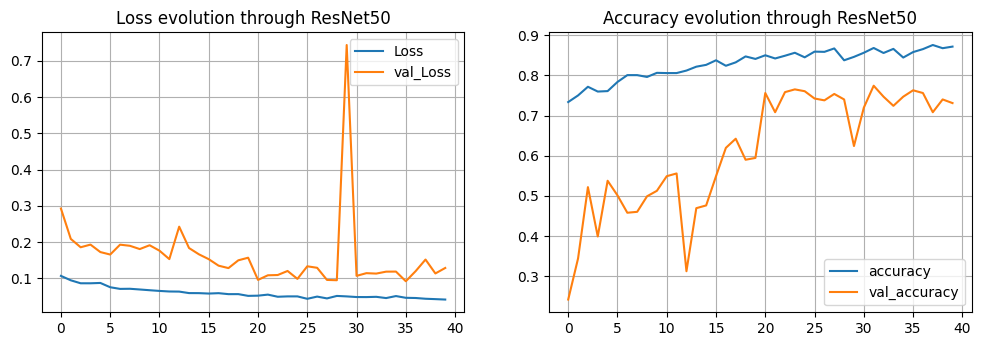

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution through ResNet50')
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution through ResNet50')

In [ ]:
from tensorflow.keras.applications import EfficientNetB4

# Load EfficientNetB4
base_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x2 = GlobalAveragePooling2D()(base_model2.output)
output2 = Dense(5, activation='softmax')(x2)
model2 = Model(inputs=base_model2.input, outputs=output2)

# Compile and train
model2.compile(tf.keras.optimizers.Adam(1e-5),loss=focal_loss(),metrics=['accuracy', F1Score()])
history2 = model2.fit(train_generator, validation_data=val_generator, epochs=40, verbose = 1, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('efficientnetb4_model.h5', save_best_only=True)
    ])

# Save the model
model2.save('efficientnetb4_model.h5')

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2649 - f1_score: 0.5823 - loss: 0.2536

55/55 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.2666 - f1_score: 0.5834 - loss: 0.2532 - val_accuracy: 0.2369 - val_f1_score: 0.6471 - val_loss: 0.2472
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5455 - f1_score: 0.7313 - loss: 0.1950 - val_accuracy: 0.1025 - val_f1_score: 0.6212 - val_loss: 0.2490
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6151 - f1_score: 0.7656 - loss: 0.1593

55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6149 - f1_score: 0.7655 - loss: 0.1593 - val_accuracy: 0.3508 - val_f1_score: 0.4727 - val_loss: 0.2226
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6246 - f1_score: 0.8039 - loss: 0.1516 - val_accuracy: 0.3235 - val_f1_score: 0.4306 - val_loss: 0.2328
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6529 - f1_score: 0.8210 - loss: 0.1421 - val_accuracy: 0.3394 - val_f1_score: 0.3581 - val_loss: 0.2282
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6744 - f1_score: 0.8392 - loss: 0.1323

55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6742 - f1_score: 0.8394 - loss: 0.1323 - val_accuracy: 0.4305 - val_f1_score: 0.4543 - val_loss: 0.2098
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6735 - f1_score: 0.8633 - loss: 0.1319 - val_accuracy: 0.4146 - val_f1_score: 0.4286 - val_loss: 0.2124
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6494 - f1_score: 0.8486 - loss: 0.1329

55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6499 - f1_score: 0.8489 - loss: 0.1329 - val_accuracy: 0.5148 - val_f1_score: 0.0000e+00 - val_loss: 0.1976
Epoch 9/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6648 - f1_score: 0.8680 - loss: 0.1333

55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6651 - f1_score: 0.8681 - loss: 0.1331 - val_accuracy: 0.5718 - val_f1_score: 0.4301 - val_loss: 0.1652
Epoch 10/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.6860 - f1_score: 0.8717 - loss: 0.1244 - val_accuracy: 0.5649 - val_f1_score: 0.3386 - val_loss: 0.1729
Epoch 11/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7029 - f1_score: 0.8857 - loss: 0.1178

55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7029 - f1_score: 0.8857 - loss: 0.1178 - val_accuracy: 0.5330 - val_f1_score: 0.7556 - val_loss: 0.1496
Epoch 12/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7164 - f1_score: 0.9178 - loss: 0.1133 - val_accuracy: 0.4624 - val_f1_score: 0.5333 - val_loss: 0.1811
Epoch 13/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6908 - f1_score: 0.8995 - loss: 0.1174 - val_accuracy: 0.5945 - val_f1_score: 0.4460 - val_loss: 0.1745
Epoch 14/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7101 - f1_score: 0.8896 - loss: 0.1103 - val_accuracy: 0.5262 - val_f1_score: 0.7823 - val_loss: 0.1516
Epoch 15/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7334 - f1_score: 0.9106 - loss: 0.1061 - val_accuracy: 0.5353 - val_f1_score: 0.7371 - val_loss: 0.1562
Epoch 16/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7199 - f1_score: 0.8941 - loss: 0.1078 - val_accuracy: 0.5171 - val_f1_score: 0.7726 - val_loss: 0.168

55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7312 - f1_score: 0.9070 - loss: 0.0960 - val_accuracy: 0.6059 - val_f1_score: 0.8341 - val_loss: 0.1437
Epoch 25/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7438 - f1_score: 0.9139 - loss: 0.0889

55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7437 - f1_score: 0.9140 - loss: 0.0889 - val_accuracy: 0.6287 - val_f1_score: 0.8372 - val_loss: 0.1254
Epoch 26/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7422 - f1_score: 0.9182 - loss: 0.0928 - val_accuracy: 0.5763 - val_f1_score: 0.8081 - val_loss: 0.1368
Epoch 27/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7539 - f1_score: 0.9336 - loss: 0.0908 - val_accuracy: 0.5763 - val_f1_score: 0.7217 - val_loss: 0.1413
Epoch 28/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7441 - f1_score: 0.9159 - loss: 0.0880 - val_accuracy: 0.6196 - val_f1_score: 0.5448 - val_loss: 0.1474
Epoch 29/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7649 - f1_score: 0.9110 - loss: 0.0878 - val_accuracy: 0.5923 - val_f1_score: 0.4840 - val_loss: 0.1526
Epoch 30/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7404 - f1_score: 0.9201 - loss: 0.0913 - val_accuracy: 0.6720 - val_f1_score: 0.8712 - val_loss: 0.12

55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7684 - f1_score: 0.9477 - loss: 0.0869 - val_accuracy: 0.6856 - val_f1_score: 0.7190 - val_loss: 0.1178
Epoch 38/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7802 - f1_score: 0.9356 - loss: 0.0802 - val_accuracy: 0.6401 - val_f1_score: 0.8522 - val_loss: 0.1240
Epoch 39/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7668 - f1_score: 0.9363 - loss: 0.0838 - val_accuracy: 0.6925 - val_f1_score: 0.7701 - val_loss: 0.1178
Epoch 40/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7833 - f1_score: 0.9408 - loss: 0.0788

55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7831 - f1_score: 0.9409 - loss: 0.0789 - val_accuracy: 0.7449 - val_f1_score: 0.8980 - val_loss: 0.0900


Text(0.5, 1.0, 'Accuracy evolution through EfficientNetB4')

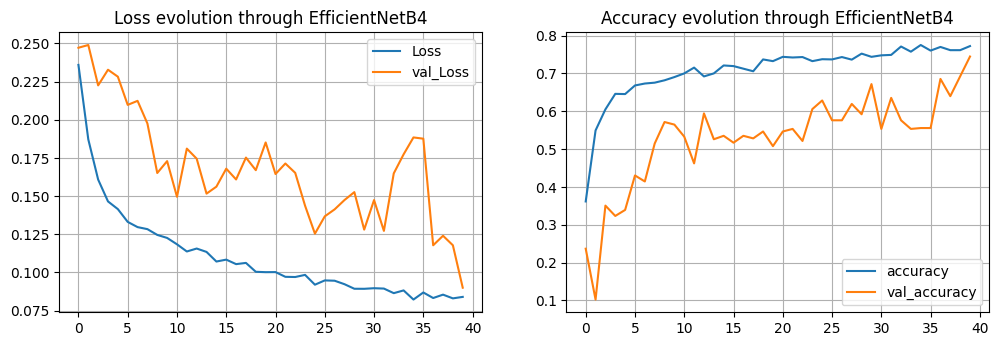

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution through EfficientNetB4')
plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution through EfficientNetB4')

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load DenseNet121
base_model3 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x3 = GlobalAveragePooling2D()(base_model3.output)
output3 = Dense(5, activation='softmax')(x3)
model3 = Model(inputs=base_model3.input, outputs=output3)

# Compile and train
model3.compile(tf.keras.optimizers.Adam(1e-5),loss=focal_loss(),metrics=['accuracy', F1Score()])
history3 = model3.fit(train_generator, validation_data=val_generator, epochs=40, verbose = 1, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('densenet121_model.h5', save_best_only=True)
    ])

# Save the model
model3.save('densenet121_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3738 - f1_score: 0.7167 - loss: 0.2368

55/55 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3760 - f1_score: 0.7179 - loss: 0.2361 - val_accuracy: 0.5125 - val_f1_score: 0.2846 - val_loss: 0.2812
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6808 - f1_score: 0.9079 - loss: 0.1320

55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6807 - f1_score: 0.9078 - loss: 0.1319 - val_accuracy: 0.5513 - val_f1_score: 0.4207 - val_loss: 0.2353
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6823 - f1_score: 0.9063 - loss: 0.1224

55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6826 - f1_score: 0.9062 - loss: 0.1224 - val_accuracy: 0.5695 - val_f1_score: 0.6019 - val_loss: 0.2055
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7139 - f1_score: 0.9130 - loss: 0.1051

55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7139 - f1_score: 0.9130 - loss: 0.1051 - val_accuracy: 0.5831 - val_f1_score: 0.7184 - val_loss: 0.1746
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7146 - f1_score: 0.9217 - loss: 0.1096

55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7149 - f1_score: 0.9218 - loss: 0.1095 - val_accuracy: 0.5125 - val_f1_score: 0.7554 - val_loss: 0.1683
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7424 - f1_score: 0.9254 - loss: 0.0953

55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7422 - f1_score: 0.9253 - loss: 0.0954 - val_accuracy: 0.6219 - val_f1_score: 0.8048 - val_loss: 0.1350
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7176 - f1_score: 0.9111 - loss: 0.0970 - val_accuracy: 0.6446 - val_f1_score: 0.8929 - val_loss: 0.1380
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7522 - f1_score: 0.9419 - loss: 0.0895

55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7523 - f1_score: 0.9418 - loss: 0.0895 - val_accuracy: 0.6811 - val_f1_score: 0.8156 - val_loss: 0.1249
Epoch 9/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7754 - f1_score: 0.9467 - loss: 0.0852

55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7752 - f1_score: 0.9465 - loss: 0.0853 - val_accuracy: 0.7175 - val_f1_score: 0.9224 - val_loss: 0.1115
Epoch 10/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7846 - f1_score: 0.9336 - loss: 0.0811

55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7843 - f1_score: 0.9336 - loss: 0.0812 - val_accuracy: 0.7244 - val_f1_score: 0.9206 - val_loss: 0.0994
Epoch 11/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7531 - f1_score: 0.9164 - loss: 0.0926 - val_accuracy: 0.7335 - val_f1_score: 0.9401 - val_loss: 0.1014
Epoch 12/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7658 - f1_score: 0.9378 - loss: 0.0827

55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7659 - f1_score: 0.9377 - loss: 0.0828 - val_accuracy: 0.7517 - val_f1_score: 0.9461 - val_loss: 0.0868
Epoch 13/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7701 - f1_score: 0.9309 - loss: 0.0821 - val_accuracy: 0.7563 - val_f1_score: 0.9086 - val_loss: 0.0909
Epoch 14/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7905 - f1_score: 0.9530 - loss: 0.0742

55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7904 - f1_score: 0.9529 - loss: 0.0742 - val_accuracy: 0.7585 - val_f1_score: 0.9242 - val_loss: 0.0847
Epoch 15/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7907 - f1_score: 0.9426 - loss: 0.0764 - val_accuracy: 0.7608 - val_f1_score: 0.9368 - val_loss: 0.0871
Epoch 16/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8029 - f1_score: 0.9457 - loss: 0.0748 - val_accuracy: 0.7403 - val_f1_score: 0.9425 - val_loss: 0.0925
Epoch 17/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8020 - f1_score: 0.9274 - loss: 0.0730 - val_accuracy: 0.7267 - val_f1_score: 0.9287 - val_loss: 0.0938
Epoch 18/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7906 - f1_score: 0.9324 - loss: 0.0773

55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7906 - f1_score: 0.9324 - loss: 0.0773 - val_accuracy: 0.7768 - val_f1_score: 0.9270 - val_loss: 0.0830
Epoch 19/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7905 - f1_score: 0.9440 - loss: 0.0780 - val_accuracy: 0.7677 - val_f1_score: 0.9395 - val_loss: 0.0883
Epoch 20/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8002 - f1_score: 0.9281 - loss: 0.0705 - val_accuracy: 0.7608 - val_f1_score: 0.9486 - val_loss: 0.0837
Epoch 21/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8207 - f1_score: 0.9423 - loss: 0.0638 - val_accuracy: 0.7563 - val_f1_score: 0.9393 - val_loss: 0.0899
Epoch 22/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7706 - f1_score: 0.9310 - loss: 0.0758 - val_accuracy: 0.7380 - val_f1_score: 0.9374 - val_loss: 0.0865
Epoch 23/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8043 - f1_score: 0.9420 - loss: 0.0679

55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8042 - f1_score: 0.9420 - loss: 0.0679 - val_accuracy: 0.7563 - val_f1_score: 0.9412 - val_loss: 0.0826
Epoch 24/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8017 - f1_score: 0.9463 - loss: 0.0690 - val_accuracy: 0.7654 - val_f1_score: 0.9323 - val_loss: 0.0869
Epoch 25/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7994 - f1_score: 0.9139 - loss: 0.0688 - val_accuracy: 0.7654 - val_f1_score: 0.9192 - val_loss: 0.0907
Epoch 26/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8107 - f1_score: 0.9302 - loss: 0.0648 - val_accuracy: 0.7494 - val_f1_score: 0.9415 - val_loss: 0.0906
Epoch 27/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8051 - f1_score: 0.9646 - loss: 0.0694 - val_accuracy: 0.7654 - val_f1_score: 0.9109 - val_loss: 0.0833
Epoch 28/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8112 - f1_score: 0.9290 - loss: 0.0636

55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8112 - f1_score: 0.9292 - loss: 0.0636 - val_accuracy: 0.7677 - val_f1_score: 0.9487 - val_loss: 0.0785
Epoch 29/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8302 - f1_score: 0.9449 - loss: 0.0604 - val_accuracy: 0.7540 - val_f1_score: 0.9398 - val_loss: 0.0862
Epoch 30/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8232 - f1_score: 0.9475 - loss: 0.0617 - val_accuracy: 0.7585 - val_f1_score: 0.9459 - val_loss: 0.0856
Epoch 31/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8187 - f1_score: 0.9443 - loss: 0.0615

55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8187 - f1_score: 0.9443 - loss: 0.0615 - val_accuracy: 0.7745 - val_f1_score: 0.9425 - val_loss: 0.0779
Epoch 32/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8299 - f1_score: 0.9640 - loss: 0.0631 - val_accuracy: 0.7904 - val_f1_score: 0.9507 - val_loss: 0.0803
Epoch 33/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8457 - f1_score: 0.9509 - loss: 0.0588 - val_accuracy: 0.7563 - val_f1_score: 0.9504 - val_loss: 0.0863
Epoch 34/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8315 - f1_score: 0.9460 - loss: 0.0598 - val_accuracy: 0.7449 - val_f1_score: 0.9398 - val_loss: 0.0873
Epoch 35/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8502 - f1_score: 0.9544 - loss: 0.0520 - val_accuracy: 0.7654 - val_f1_score: 0.9484 - val_loss: 0.0842
Epoch 36/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8364 - f1_score: 0.9513 - loss: 0.0539 - val_accuracy: 0.7449 - val_f1_score: 0.9464 - val_loss: 0.085

55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8246 - f1_score: 0.9612 - loss: 0.0586 - val_accuracy: 0.7654 - val_f1_score: 0.9533 - val_loss: 0.0744
Epoch 40/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8294 - f1_score: 0.9412 - loss: 0.0581 - val_accuracy: 0.7608 - val_f1_score: 0.9324 - val_loss: 0.0875


In [ ]:
from tensorflow.keras.models import load_model

# Load trained models
model1 = load_model('best_model.h5')
model2 = load_model('efficientnetb4_model.h5')

In [ ]:
history3 = model3

Text(0.5, 1.0, 'Accuracy evolution through DenseNet121')

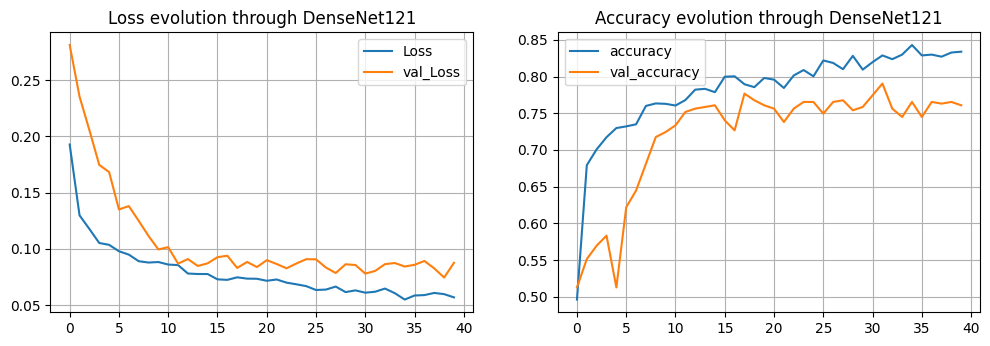

In [ ]:
#Visualizing the training performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution through DenseNet121')
plt.subplot(2, 2, 2)
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution through DenseNet121')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predicted probabilities
val_true = val_generator.labels  # True labels
val_pred_probs = model3.predict(val_generator)  # Predicted probabilities
val_pred = np.argmax(val_pred_probs, axis=1)  # Convert to class labels (0-4)

# Generate classification report
print("Classification Report:")
print(classification_report(val_true, val_pred, target_names=['0', '1', '2', '3', '4']))


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 661ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       229
           1       0.07      0.06      0.07        49
           2       0.24      0.34      0.28       104
           3       0.00      0.00      0.00        21
           4       0.05      0.03      0.03        36

    accuracy                           0.35       439
   macro avg       0.18      0.18      0.18       439
weighted avg       0.34      0.35      0.34       439

